# Sveikatos draudimo kainos ir jai darančių įtaką kintamųjų analizė

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Tam, kad analizę skaityti būtų paprasčiau, kodas yra paslėptas"></form>''')

Ši analizė skirta nustatyti kriterijus, veikiančius sveikatos draudimo kainą. Naudojami duomenys yra paimti iš autoriaus Brett Lantz knygos "Machine Learning with R". Duomenys yra paremti JAV cenzu ir galima teigti, kad atitinka realią situaciją šalyje. TUrimi duomenys yra korespondentų amžius, lytis, kūno masės indeksas (KMI, angliškai - BMI), turimų vaikų skaičius, rūkymo istorija, regionas ir bendra kaina mokama už draudimą. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df["smoker"] = df['smoker'].replace(
    {
        "yes" : 1,
        "no" : 0
    }
)
df["sex"] = df['sex'].replace(
    {
        "male" : 1,
        "female" : 0
    }
)

Analizės pradžioje, peržiūrėjau bendrą informaciją apie duomenis bei koreliacijas tarp kintamųjų.



##### Lentelė 1

Skaitinių reikšmių vidurkiai, standartiniai nuokrypiai, didžiausios ir mažiausios reikšmės, kvartiliai ir medianos.

In [5]:
df.describe().drop('count')

,age,sex,bmi,children,smoker,charges
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010


##### Lentelė 2

Koreliacijos tarp kintamųjų. Kuo skaičius arčiau 1 tuo artimesnė koreliacija. Neigiami skaičiai reiškia atvirkštinę koreliaciją (kai vienas kintamasis didėja, kitas mažėja)

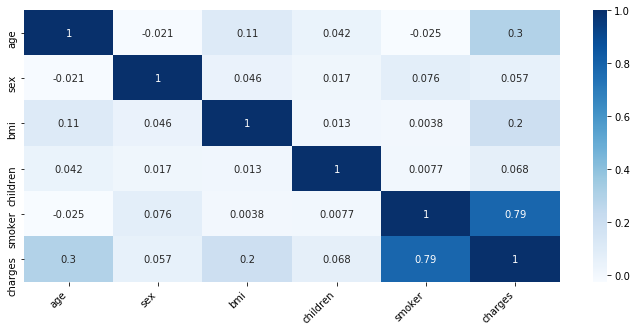

In [6]:
plt.figure(figsize=(12,5))
chart = sns.heatmap(df.corr(), cmap = "Blues", annot = True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart

Kadangi analizės tikslas yra nustatyti koreliacijas tarp draudimo kainos ir kitų kriterijų, kitos koreliacijos nebus analizuojamos. Matome, jog koreliacijos tarp draudimo kainos ir vaikų skaičiaus ar lyties yra statistiškai nereikšmingos. Todėl galima teigti, kad lytis ir vaikų kiekis neturi beveik jokios įtakos draudimo kainai.

##### Lentelė 3

Kainos koreliacijos su kitais kintamaisiais.

In [7]:
df.corr().charges.sort_values(ascending = False).drop("charges")

smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
Name: charges, dtype: float64

Peržiūrint duomenų pasiskirstymus, galima padaryti kelis įdomius pastebėjimus. Pirma, mūsų imtyje yra neproporcingai daug ~20 metų amžiaus žmonių (Lentelė 4). Taip pat galima pastebėti, kad didžiosios dalies žmonių kūno masės indeksas (BMI) viršija 30, kas žymi nutukimą (Lentelė 5).

##### Lentelė 4

Korespondentų pasiskirstymas pagal amžių.

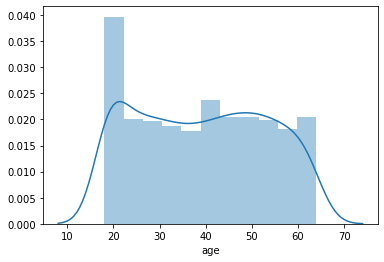

In [8]:
sns.distplot(df["age"])

##### Lentelė 5

Korespondentų pasiskirstymas pagal kūno masės indeksą.

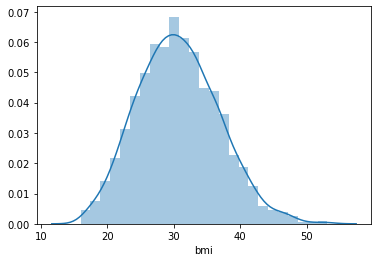

In [9]:
sns.distplot(df["bmi"])

Kaip jau prieš tai matėme lentelėje 3, draudimo kaina turi didžiausią koreliaciją su rūkymo istorija. Sugrupavus korespondentus į rūkančius ir nerūkančius, galima matyti, jog rūkantieji už draudimą vidutiniškai moka 20000 - 30000 daugiau.

##### Lentelė 6

Draudimo kainos pasiskirstymas pagal rūkymo istoriją. 0 žymi nerūkančiuosius, 1 žymi rūkančiuosius.

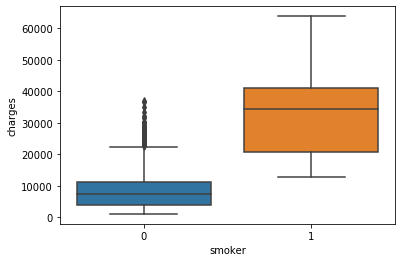

In [10]:
sns.boxplot(df['smoker'], df['charges'])

In [11]:
df_nosmoke = df.loc[df['smoker'] == 0]
df_smoke = df.loc[df['smoker'] == 1]

Sekančioje lentelėje atvaizduoti visi keturi pagrindiniai rodikliai: amžius (horizontali ašis), rūkymo statusas (apskritimo spalva), KMI (apskritimo dydis) ir draudimo kaina (vertikali ašis). Galima pastebėti, kad amžius ir kaina sudaro ryškią linijinę progresiją. Taip pat, kaip ir lentelėje 6, matomas ryškus kainos pasiskirstymas pagal rūkymo istoriją. Tačiau lentelėje 7 rūkantieji pasiskirstė į dar dvi grupes.

##### Lentelė 7

Rodiklių pasiskirstymas.

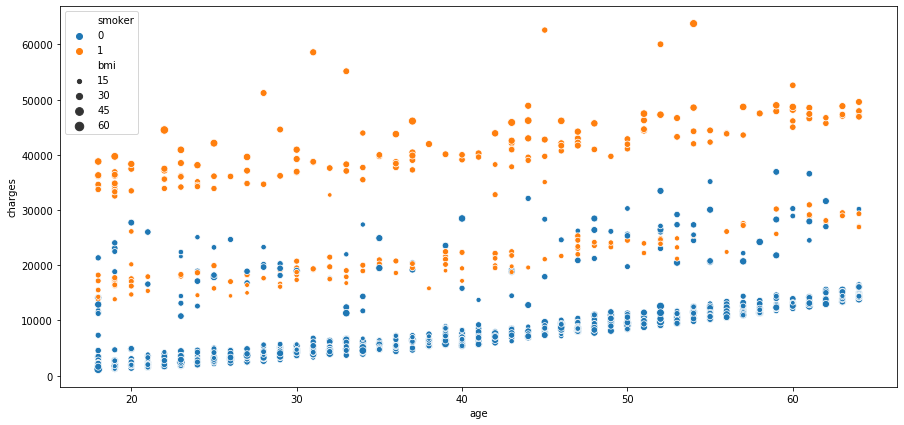

In [12]:
plt.figure(figsize=(15,7))
sns.scatterplot(df['age'], df['charges'], hue=df['smoker'], size = df['bmi'])

Rūkančiųjų pasiskirstymą galima paaiškinti KMI perkėlus į horizontalią ašį, o amžių atvaizdavus apskritimo dydžiu. Kainos lūžis ivyksta, kai KMI perkopia 30. Kaip minėta anksčiau, KMI virš 30 žymi nutukimą. Verta pastebėti, kad KMI neturi ryškios įtakos nerūkančiųjų draudimo kainai.

##### Lentelė 8

Visų korespondentų sveikatos draudimų kainos pagal KMI:

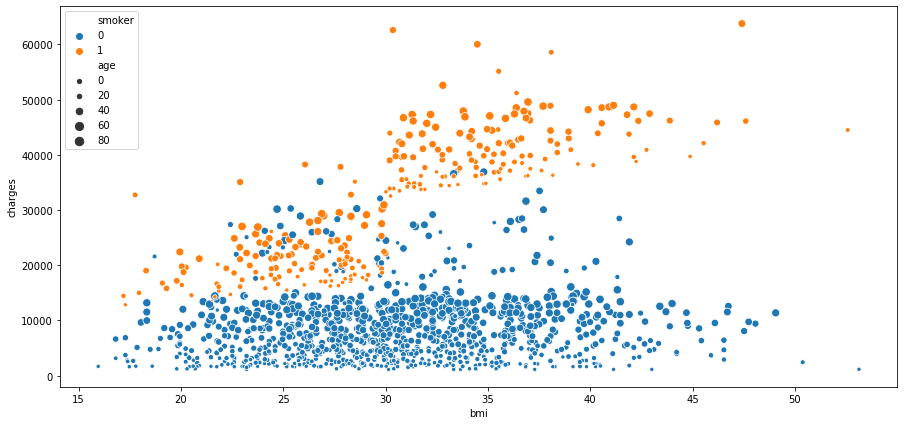

In [13]:
plt.figure(figsize=(15,7))
sns.scatterplot(df['bmi'], df['charges'], hue=df['smoker'], size=df['age'])


In [14]:
df['obese'] = df['bmi'] >= 30

Toliau galima pastebėti, kad išskirsčius koresppondentus į nerūkančius (lentelė 9), rūkančius be nutukimo (lentelė 10) ir rūkančius su nutukimu (lentelė 11), mes vėl matome tuos pačius pasiskirstymus tarp amžiaus ir draudimo kainos - linijinę progresiją. 

Taip pat matome, kad yra gana nemažas kiekis korespondentų, kurių draudimo kaina yra ryškiai aukštesnė, nei jų kategorija turėtų diktuoti. Kadangi turimuose duomenyse nepavyko rasti daugiau jokių korealiacijų, galima kelti hipotezę, jog šie kainos neatitikimai susiję su korespondentų ligų istorijomis. Tolimesnes įžvalgas būtų galima daryti gavus prieeigą prie šios informacijos.

##### Lentelė 9

Nerūkančių žmonių sveikatos draudimų kainos pagal amžių:

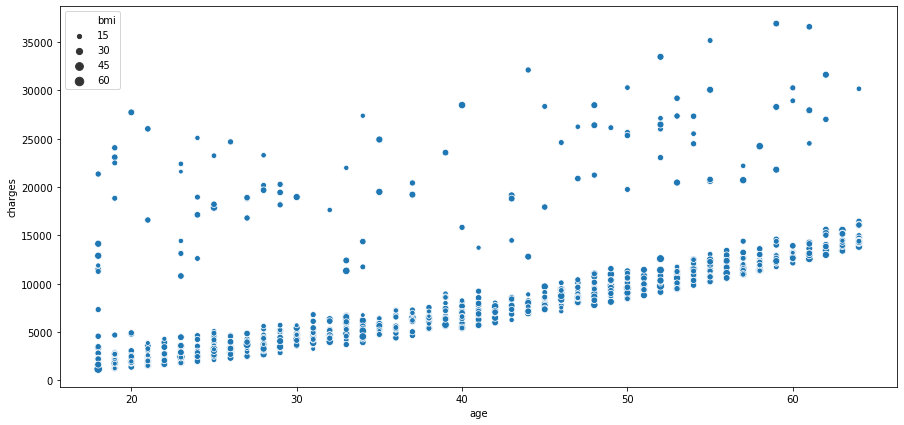

In [15]:
plt.figure(figsize=(15,7))
sns.scatterplot(
    df_nosmoke['age'], 
    df_nosmoke['charges'], 
    size = df_nosmoke['bmi']
)

##### Lentelė 10

Rūkančių žmonių be nutukimo draudimo kainos pagal amžių:

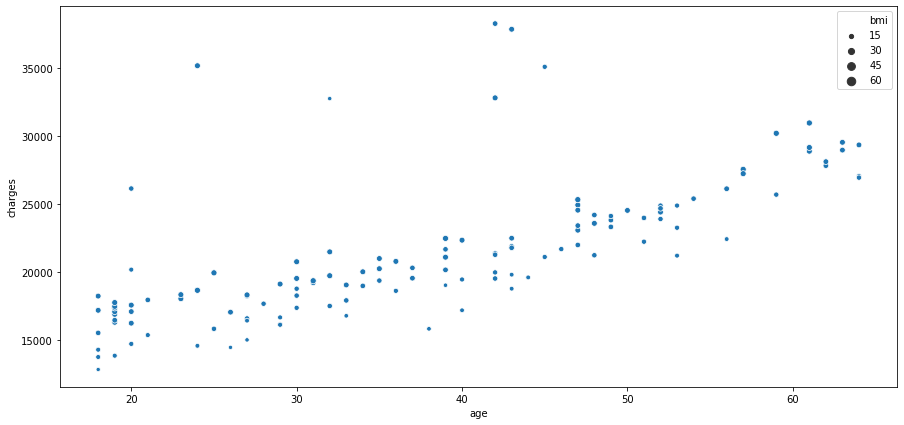

In [16]:
plt.figure(figsize=(15,7))
sns.scatterplot(
    df_smoke['age'].loc[~df['obese']], 
    df_smoke['charges'],
    size = df_smoke['bmi']
)

##### Lentelė 11

Rūkančių žmonių su nutukimu draudimo kainos pagal amžių:

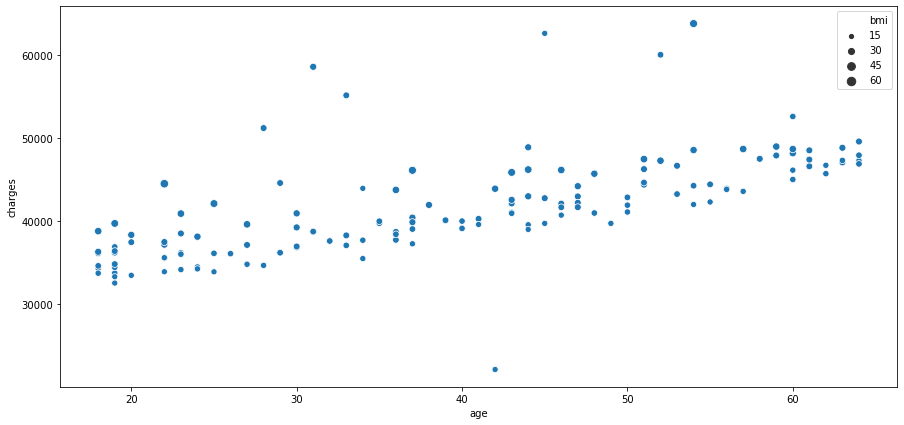

In [17]:
plt.figure(figsize=(15,7))
sns.scatterplot(
    df_smoke['age'].loc[df['obese']], 
    df_smoke['charges'],
    size = df_smoke['bmi']
)

### Išvados

1. Didžiausią įtaką draudimo kainai daro korespondento rūkymo istorija.
2. Rūkančiųjų korespondentų draudimo kainai didelę įtaką daro jų kūno masės indeksas.
3. Nerūkančiųjų korespondentų draudimo kainai jų KMI įtakos neturi.
4. Atmetus kitus rodiklius, draudimo kaina ir korespondento amžius sudaro linijinę progresiją.
5. Korespondento lytis, turimų vaikų skaičius ir regionas draudimo kainai įtakos neturi.
6. Išimtinius duomenis galima bandyti paaiškinti per korespondentų ligų istoriją tolimesniuose tyrimuose

# Machine Learning

Sekantis tikslas - pasitelkti mašininio mokymosi modelius draudimo kainos apskaičiavimui. Atsakymų tikslumui patikrinti naudoju 5 sluoksnių kryžminio patikrinimo (angl. cross-validation) vidurkius. Modeliams pateikti duomenys buvo išvalyti nuo reikšmių, kurių kainų paaiškinti nepavyko. Išvadas apie kiekvieną modelį galima matyti po jo rezultatais.

In [18]:
dfm = df.copy()

In [19]:
dfm = pd.get_dummies(dfm)

In [20]:
dfm['irregular'] = (
    (
        (dfm['charges'] / dfm['age'] > 260)
        & 
        (dfm['smoker'] == 0)
    ) | 
    (
        (
            (
                (dfm['charges'] / dfm['age'] > 350 + (15000 /dfm['age']))
                &
                ~dfm['obese']
            ) 
            | 
            (
                (dfm['charges'] / dfm['age'] > 350 + (35000 /dfm['age']))
                &
                dfm['obese']
            )
        ) 
        & 
        (dfm['smoker'] == 1)
    )
)
dfm = dfm.loc[dfm['irregular']==0].drop('irregular', axis=1)

In [21]:
test_values = [
    'neg_mean_absolute_error',
    'neg_median_absolute_error',
    'r2',
    'neg_mean_squared_error'
]

In [22]:
y = dfm['charges']
X = dfm.drop('charges', axis=1)

### Linear Regression modelis

In [23]:
model = LinearRegression()

Modelio skaičiavimo rezultatai:

In [24]:
pd.DataFrame(cross_validate(model, X, y, scoring=test_values)).mean()

fit_time                          9.089565e-03
score_time                        5.972576e-03
test_neg_mean_absolute_error     -3.341645e+03
test_neg_median_absolute_error   -2.353803e+03
test_r2                           8.684466e-01
test_neg_mean_squared_error      -1.790452e+07
dtype: float64

Originalių reikšmių ir gautų rezultatų palyginimas.
Horizontali ašis - Originalios reikšmės
Vertikali ašis - Modelio skaičiavimai

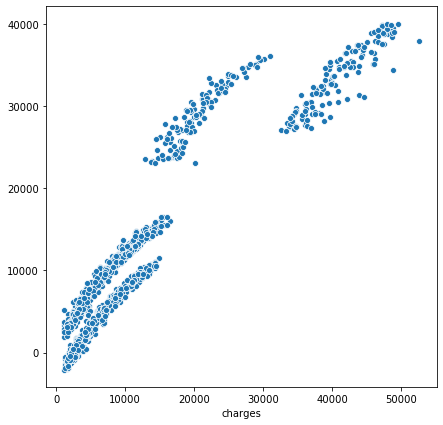

In [25]:
y_pred = cross_val_predict(model, X, y)
plt.figure(figsize=(7,7))
sns.scatterplot(y, y_pred)

Linear regression modelis darbą atliko, bet akivaizdžiai matomi keli trūkiai atsakymuose. Analizuodamas duomenis, modelis neįvertino KMI reikšmės svorio pasikeitimo tarp rūkančių ir nerūkančių žmonių ir paėmė jų vidurkį.

### Lasso modelis

In [26]:
model2 = Lasso()

Modelio skaičiavimo rezultatai:

In [27]:
pd.DataFrame(cross_validate(model2, X, y, scoring=test_values)).mean()

fit_time                          9.302425e-03
score_time                        3.880978e-03
test_neg_mean_absolute_error     -3.340536e+03
test_neg_median_absolute_error   -2.353458e+03
test_r2                           8.684549e-01
test_neg_mean_squared_error      -1.790339e+07
dtype: float64

Originalių reikšmių ir gautų rezultatų palyginimas.
Horizontali ašis - Originalios reikšmės
Vertikali ašis - Modelio skaičiavimai

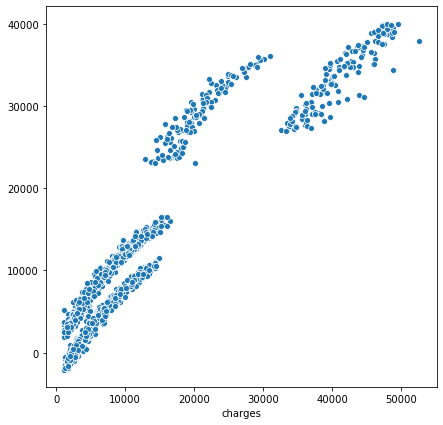

In [28]:
y_pred2 = cross_val_predict(model2, X, y)
plt.figure(figsize=(7,7))
sns.scatterplot(y, y_pred2)

Nors lasso modelis davė kiek tikslesnius rezultatus, esminė problema yra tokia pati, kaip ir linear regression modelyje.

### ElasticNet modelis

In [29]:
model3 = ElasticNet()

Modelio skaičiavimo rezultatai:

In [30]:
pd.DataFrame(cross_validate(model3, X, y, scoring=test_values)).mean()

fit_time                          9.499788e-03
score_time                        2.433920e-03
test_neg_mean_absolute_error     -6.146894e+03
test_neg_median_absolute_error   -4.497415e+03
test_r2                           4.501517e-01
test_neg_mean_squared_error      -7.485921e+07
dtype: float64

Originalių reikšmių ir gautų rezultatų palyginimas.
Horizontali ašis - Originalios reikšmės
Vertikali ašis - Modelio skaičiavimai

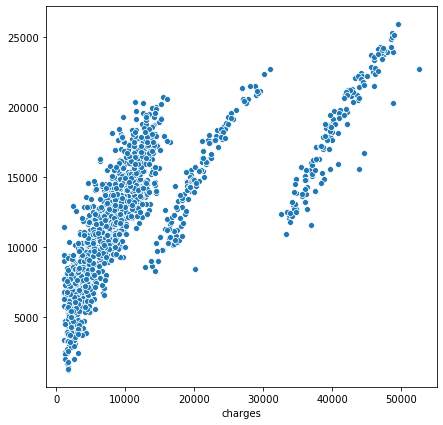

In [31]:
y_pred3 = cross_val_predict(model3, X, y)
plt.figure(figsize=(7,7))
sns.scatterplot(y, y_pred3)

ElasticNet modelio rezultatai yra dar prastesni - šis modelis yra dar toliau nuo norimo atsakymo. Modelis neteisingai įvertino rūkymo reikšmės svorį, vietoj to visą svarbą atiduodamas amžiaus kriterijui.

### Random forest modelis 

In [32]:
model4 = RandomForestRegressor(random_state = 420)

Modelio skaičiavimo rezultatai:

In [33]:
pd.DataFrame(cross_validate(model4, X, y, scoring=test_values)).mean()

fit_time                               0.725613
score_time                             0.020573
test_neg_mean_absolute_error        -390.184908
test_neg_median_absolute_error      -214.304911
test_r2                                0.994592
test_neg_mean_squared_error      -729067.710968
dtype: float64

Originalių reikšmių ir gautų rezultatų palyginimas.
Horizontali ašis - Originalios reikšmės
Vertikali ašis - Modelio skaičiavimai

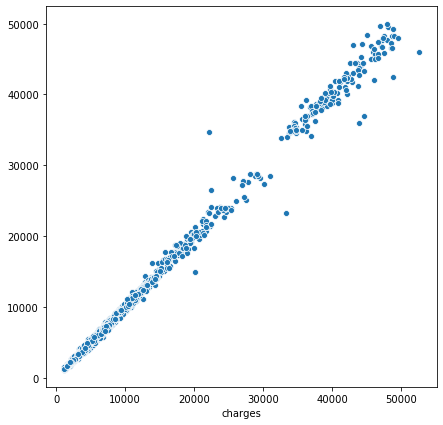

In [34]:
y_pred4 = cross_val_predict(model4, X, y)
plt.figure(figsize=(7,7))
sns.scatterplot(y, y_pred4)

Random forest modelio rezultatai tikslesni. Apart kelių neatitikimų, visi kriterijai buvo įvertinti teisingai. Pabandžius tam pačiam algoritmui pateikti neišvalytus duomenis, modelio atsakymų tikslumas sumažėjo, todėl nusprendžiau visus modelius vertinti tik pagal jų sugebėjimą apdoroti išvalytus duomenis. Šis modelis duoda patenkinamus rezultatus šios analizės rėžiuose. Tolimesni skaičiavimo tobulinimai turėtų stengtis paaiškinti iki šiol nepaaiškintus duomenis.